In [2]:
using Gridap, Gridap.Geometry, Gridap.Fields
using Gmsh, GridapGmsh
using GLMakie, DelimitedFiles, Interpolations
using LinearAlgebra, SparseArrays, KrylovKit
using ChainRulesCore, Zygote
using PartitionedArrays
using NLopt
using GridapMakie

import Gridap.CellData: Interpolable
import ChainRulesCore: rrule
import Gmsh: gmsh


main_path = "/Users/jayyao/Documents/Research/RamanInFluid/"
include(main_path*"Materials/Materials.jl")
include(main_path*"Module/Mesh_Periodic.jl")
include(main_path*"Module/Helper.jl")
include(main_path*"Module/GridapFE.jl")
include(main_path*"Module/Control.jl")
include(main_path*"Module/Model.jl")
include(main_path*"Module/Objective.jl")

g0_p_optimize (generic function with 3 methods)

In [3]:
hr = 549/sqrt(1.77)          # Height of Raman molecule
# Geometry parameters of the mesh
L = 150           # Length of the normal region
hair = 500 + hr       # Height of the air region
hs = 300 + hr         # Height of the source location in air
ht = 200 + hr         # Height of the target location in air
hd = 200          # Height of design domain
hsub = 100        # Height of substrate domain below design domain
dpml = 300        # Thickness of the PML
hrd = [hd, hr]
# Characteristic length (controls the resolution, smaller the finer)
resol = 30        # Number of points per wavelength
l1 = L/resol      # Air
l2 = l1/2.0       # Design domain
l3 = l1           # PML

meshfile = "geometry.msh"
geo_param = PeriodicGeometry(L, hair, hs, ht, hd, hsub, dpml, l1, l2, l3)
MeshGenerator(geo_param, meshfile)
# run(`scp wyao@txe1-login.mit.edu:/home/gridsan/wyao/Research/RamanInFluid/cloud/task1/geometry.msh /Users/jayyao/Documents/Research/RamanInFluid/`)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (L

In [4]:
############  Optimization parameters #############
flag_f = true       # Turn on filter
flag_t = true       # Turn on threshold

# Filter and threshold paramters
r = [0.02 * L, 0.02 * L]  # Filter radius
β = 80.0                  # β∈[1,∞], threshold sharpness
η = 0.5                   # η∈[0,1], threshold center

α = 0.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

# Number of subspace
K = 20

# Amplify g for NLopt
Amp = 1

# Sum over kx
nkx = 30
nparts = nkx / 2

Bp = true          # Matrix B depend on parameters?
pv = 1

# Foundary constraint parameters
c = 0#resol^4
lw = r[1]
ls = r[1]
ηe = fηe(lw / r[1])
ηd = fηd(lw / r[1])

control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f, true)


Info    : Reading 'geometry.msh'...
Info    : 45 entities
Info    : 22769 nodes
Info    : 44808 elements
Info    : Done reading 'geometry.msh'


GridapParameters(UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), 11110, BodyFittedTriangulation(), Measure(), Measure(), Measure(), Measure(), Measure(), Measure(), GenericCellField(), Int8[8, 8, 8, 8, 8, 8, 8, 8, 8, 8  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 7)

In [5]:

material = "Silver"
n_λ, k_λ = RefractiveIndex(material,main_path)
λ1 = 532
λ2 = 549
nm1 = n_λ(λ1) + 1im * k_λ(λ1)
nm2 = n_λ(λ2) + 1im * k_λ(λ2)
nf = sqrt(1.77)
μ = 1
R = 1e-10
LHp=[Inf, hair + hd]  # Start of PML for x,y > 0
LHn=[Inf, hsub]       # Start of PML for x,y < 0


ω1 = 2 * π / λ1
phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
ω2 = 2 * π / λ2
phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)


# kb = 0. * ω1
# p0 = zeros(gridap.np)
# p_vec = p_extend(p0; gridap)
# pf_vec = Filter(p_vec; control, gridap)
# pf_vec[pf_vec .< 0] .= 0
# pf_vec[pf_vec .> 1] .= 1.0
# pfh = FEFunction(gridap.FE_Pf, pf_vec)
# pth = (pf -> Threshold(pf; control)) ∘ pfh

# A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)

# btest(v) = ∫(v)gridap.dΓ_s
# b_vec = assemble_vector(btest, gridap.FE_V)

# u1_vec = A1_mat\b_vec
# u1h = FEFunction(gridap.FE_U, u1_vec)
# A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
# o_vec = VectorO(1, 1; gridap)
# v2_vec = A2_mat' \ o_vec
# v2h = FEFunction(gridap.FE_U, v2_vec)

# fig, ax, plt = plot(gridap.Ω, real(u1h), colormap=:bwr)
# Colorbar(fig[1,2], plt)
# ax.aspect = AxisAspect(L/(phys1.LHn[2]+phys1.LHp[2]))
# limits!(ax, -L/2, L/2, -phys1.LHn[2], phys1.LHp[2])
# fig

PhysicalParameters(0.011444781980290685, 1.3304134695650072, 0.12536326530612246 + 3.330816326530612im, 0.12536326530612246 + 3.330816326530612im, 1.0, 1.0e-10, 300.0, [Inf, 1112.653669373553], [Inf, 100.0], 200.0)

In [6]:
kb = 0
p_init = ones(gridap.np)

pf_vec = pf_p0(p_init; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v)gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat\b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

B_mat = MatrixB(pth, u1h; control, gridap)
B0_mat = MatrixB0(pth, λ2/nf*0.99, u1h; control, gridap)
# B1_mat = MatrixB0(2*λ2/nf, u1h; control, gridap)

A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
o_vec = VectorO(1, 1; gridap)
v2_vec = A2_mat'\o_vec
gp = real(v2_vec' * B_mat * v2_vec)
g0 = real(v2_vec' * B0_mat * v2_vec)
gp, g0

(210815.49958346083, 210656.06654909937)

In [ ]:
# p_init_fun(x) = x[2] < 0.6 * hd ? 1 : 0
# lc_temp(v) = ∫(v * x->p_init_fun(x))gridap.dΩ
# pc_vec = assemble_vector(lc_temp, gridap.FE_P)
# p_init = p_extract(pc_vec; gridap)

# #p_init[p_init .< 0.5] .= 0
# p_init[p_init .> 0] .= 1
# sum(p_init) / gridap.np
function p_bowtie(x, d, h, L, hd)
    dx = abs(x[1]) - d / 2 
    dy = abs(x[2] - hd / 2)
    bowtie = 0
    if dx >= 0 && dy <= h / (L - d) * dx
        bowtie = 1
    end
    return bowtie
end

kb = 0
d = 0
h = 100
bowtie_temp(v) = ∫(v * x->p_bowtie(x, d, h, L, hd))gridap.dΩ
pc_vec = assemble_vector(bowtie_temp, gridap.FE_P)
p_init = p_extract(pc_vec; gridap)
p_init[p_init .< 0.5] .= 0
p_init[p_init .> 0.5] .= 1

In [ ]:
# p_init = rand(gridap.np) * 0.9 + rand(gridap.np) * 1e-2
β_list = [5.0, 10.0, 20.0, 30.0, 40.0, 60.0, 80.0]
# β_list = [80.0, 80.0, 80.0, 80.0, 80.0]

g_opt = 0
for bi = 1 : 7
    β = β_list[bi]
    control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

    if bi == 1
        g_opt, p_opt = g0_p_optimize(p_init, 1e-12, 200; phys1, phys2, control, gridap)
    
    else
        g_opt, p_opt = g0_p_optimize([], 1e-12, 200; phys1, phys2, control, gridap)
    end
    if isfile("p_opt.value.txt")
        run(`rm p_opt_value.txt`)
    end
    open("p_opt_value.txt", "w") do iop
        for i = 1 : length(p_opt)
            p_temp = p_opt[i]
            write(iop, "$p_temp \n")
        end
    end
    open("g_opt_value.txt", "a") do io
        write(io, "$g_opt \n")
    end
end
@show g_opt

In [ ]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
if ImportFromFile
    #p_max = readdlm("cloud/task5/p_opt_value.txt", Float64)
    p_max = readdlm("p_opt_value.txt", Float64)
    p0 = p_max[:]
else
    p0 = zeros(gridap.np)
end

kb = 0
pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v)gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
o_vec = VectorO(1, 1; gridap)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)

fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
save("Results/shape.png", fig)
fig

In [ ]:
maxv = maximum(abs.(u1_vec))/10
#fig, ax, plt = plot(gridap.Ω, real(u1h), colormap = :bwr, colorrange=(-maxv, maxv))
fig, ax, plt = plot(gridap.Ω, abs(u1h), colormap = :hot)
Colorbar(fig[1,2], plt)
ax.title = "Design Shape"
#ax.aspect = AxisAspect(L/(phys1.LHp[2]+phys1.LHn[2]))
#limits!(ax, -L/2, L/2, -phys1.LHn[2], phys1.LHp[2])
ax.aspect = AxisAspect(L/(hd+hr))
limits!(ax, -L/2, L/2, 0, hd+hr)
fig

In [ ]:
gvalues = readdlm("gvalue.txt", Float64)
gavlues = gvalues[:]
GLMakie.lines(range(1, length=length(gvalues)), gvalues[:])
# grad = zeros(gridap.np)
# g0_p(p0, grad; kb, phys1, phys2, control, gridap)


In [ ]:
p0 = rand(gridap.np)
δp = rand(gridap.np)*1e-8
grad = zeros(gridap.np)

kb = 0.0 * ω1
g0 = g0_p(p0, grad; kb, phys1, phys2, control, gridap)
g1 = g0_p(p0+δp, []; kb, phys1, phys2, control, gridap)
g1-g0, grad'*δp
#1.609129978462141e8

In [ ]:
Nh = 11
hlist = zeros(Nh)
glist = zeros(Nh)
for hi = 1:Nh
hlist[hi] = (hi-1)*hd/(Nh-1)
p_init_fun(x) = 1-1/(1+exp(-(x[2]-hlist[hi])))
lc_temp(v) = ∫(v * x->p_init_fun(x))gridap.dΩ
pc_vec = assemble_vector(lc_temp, gridap.FE_P)
p_init = p_extract(pc_vec; gridap)
glist[hi] = g0_p(p_init, []; kb=0, phys1, phys2, control, gridap)
end

In [ ]:
p_init_fun(x) = 1-1/(1+exp(-(x[2]-0.7*hd)))
lc_temp(v) = ∫(v * x->p_init_fun(x))gridap.dΩ
pc_vec = assemble_vector(lc_temp, gridap.FE_P)
p_init = p_extract(pc_vec; gridap)
pf_vec = pf_p0(p_init; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
fig

In [ ]:
function p_bowtie(x, d, h, L, hd)
    dx = abs(x[1]) - d / 2 
    dy = abs(x[2] - hd / 2)
    bowtie = 0
    if dx >= 0 && dy <= h / (L - d) * dx
        bowtie = 1
    end
    return bowtie
end

kb = 0
d = 80
h = 20
bowtie_temp(v) = ∫(v * x->p_bowtie(x, d, h, L, hd))gridap.dΩ
pc_vec = assemble_vector(bowtie_temp, gridap.FE_P)
p0 = p_extract(pc_vec; gridap)
@show g0_p(p0, []; kb, phys1, phys2, control, gridap)

pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v)gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
o_vec = VectorO(1, 1; gridap)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)


fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
#save("Results/shape.png", fig)
fig

In [ ]:
gmax = 0
dmax = 0
hmax = 0
for d = 10:10:150
    for h = 10:10:200
        bowtie_temp(v) = ∫(v * x->p_bowtie(x, d, h, L, hd))gridap.dΩ
        pc_vec = assemble_vector(bowtie_temp, gridap.FE_P)
        p0 = p_extract(pc_vec; gridap)
        @show gtemp = g0_p(p0, []; kb=0, phys1, phys2, control, gridap)
        if gtemp > gmax
            gmax = gtemp
            dmax = d
            hmax = h
        end
    end
end
gmax, dmax, hmax

In [14]:
function p_bowtie(x, d, h, L, hd)
    dx = abs(x[1]) - d / 2 
    dy = abs(x[2] - hd / 2)
    bowtie = 0
    if dx >= 0 && dy <= h / (L - d) * dx
        bowtie = 1
    end
    return bowtie
end

function g_hr(hr)
    # Geometry parameters of the mesh
    L = 150           # Length of the normal region
    hair = 500 + hr       # Height of the air region
    hs = 300 + hr         # Height of the source location in air
    ht = 200 + hr         # Height of the target location in air
    hd = 200          # Height of design domain
    hsub = 100        # Height of substrate domain below design domain
    dpml = 300        # Thickness of the PML
    hrd = [hd, hr]
    # Characteristic length (controls the resolution, smaller the finer)
    resol = 30        # Number of points per wavelength
    l1 = L/resol      # Air
    l2 = l1/2.0       # Design domain
    l3 = l1           # PML

    meshfile = "geometry.msh"
    geo_param = PeriodicGeometry(L, hair, hs, ht, hd, hsub, dpml, l1, l2, l3)
    MeshGenerator(geo_param, meshfile)

    ############  Optimization parameters #############
    flag_f = true       # Turn on filter
    flag_t = true       # Turn on threshold

    # Filter and threshold paramters
    r = [0.02 * L, 0.02 * L]  # Filter radius
    β = 80.0                  # β∈[1,∞], threshold sharpness
    η = 0.5                   # η∈[0,1], threshold center

    α = 0.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

    # Number of subspace
    K = 20

    # Amplify g for NLopt
    Amp = 1

    # Sum over kx
    nkx = 30
    nparts = nkx / 2

    Bp = true          # Matrix B depend on parameters?
    pv = 1
    kb = 0
    
    # Foundary constraint parameters
    c = 0#resol^4
    lw = r[1]
    ls = r[1]
    ηe = fηe(lw / r[1])
    ηd = fηd(lw / r[1])

    control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

    gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f, true)
    
    material = "Silver"
    n_λ, k_λ = RefractiveIndex(material,main_path)
    λ1 = 532
    λ2 = 549
    nm1 = n_λ(λ1) + 1im * k_λ(λ1)
    nm2 = n_λ(λ2) + 1im * k_λ(λ2)
    nf = sqrt(1.77)
    μ = 1
    R = 1e-10
    LHp=[Inf, hair + hd]  # Start of PML for x,y > 0
    LHn=[Inf, hsub]       # Start of PML for x,y < 0


    ω1 = 2 * π / λ1
    phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
    ω2 = 2 * π / λ2
    phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)

#     d = 40
#     h = 100
#     bowtie_temp(v) = ∫(v * x->p_bowtie(x, d, h, L, hd))gridap.dΩ
#     pc_vec = assemble_vector(bowtie_temp, gridap.FE_P)
#     pbowtie = p_extract(pc_vec; gridap)
    p_init = ones(gridap.np)

    pf_vec = pf_p0(p_init; control, gridap)
    pfh = FEFunction(gridap.FE_Pf, pf_vec)
    pth = (pf -> Threshold(pf; control)) ∘ pfh
    A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)
    b1_vec = assemble_vector(v->(∫(v)gridap.dΓ_s), gridap.FE_V)
    u1_vec = A1_mat\b1_vec
    u1h = FEFunction(gridap.FE_U, u1_vec)

    B_mat = MatrixB0(pth, λ2/nf/2, u1h; control, gridap)
    B0_mat = MatrixB0(pth, λ2/nf, u1h; control, gridap)
    B1_mat = MatrixB0(pth, 1.5*λ2/nf, u1h; control, gridap)
    
    A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
    o_vec = VectorO(1, 1; gridap)
    v2_vec = A2_mat'\o_vec
    gp = real(v2_vec' * B_mat * v2_vec)
    g0 = real(v2_vec' * B0_mat * v2_vec)
    g1 = real(v2_vec' * B1_mat * v2_vec)
    return gp, g0, g1
end

g_hr (generic function with 1 method)

In [15]:
Ng = 20
g_list = zeros(Ng)
g0_list = zeros(Ng)
g1_list = zeros(Ng)
h_list = zeros(Ng)

for hi = 1:Ng
    print(hi,"\n")
    λ2 = 549/sqrt(1.77)
    hr = (hi+2) * λ2 / 2
    h_list[hi] = hr/λ2
    gp, g0, g1= g_hr(hr)
    g_list[hi] = gp
    g0_list[hi] = g0
    g1_list[hi] = g1
end

1
Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : 

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

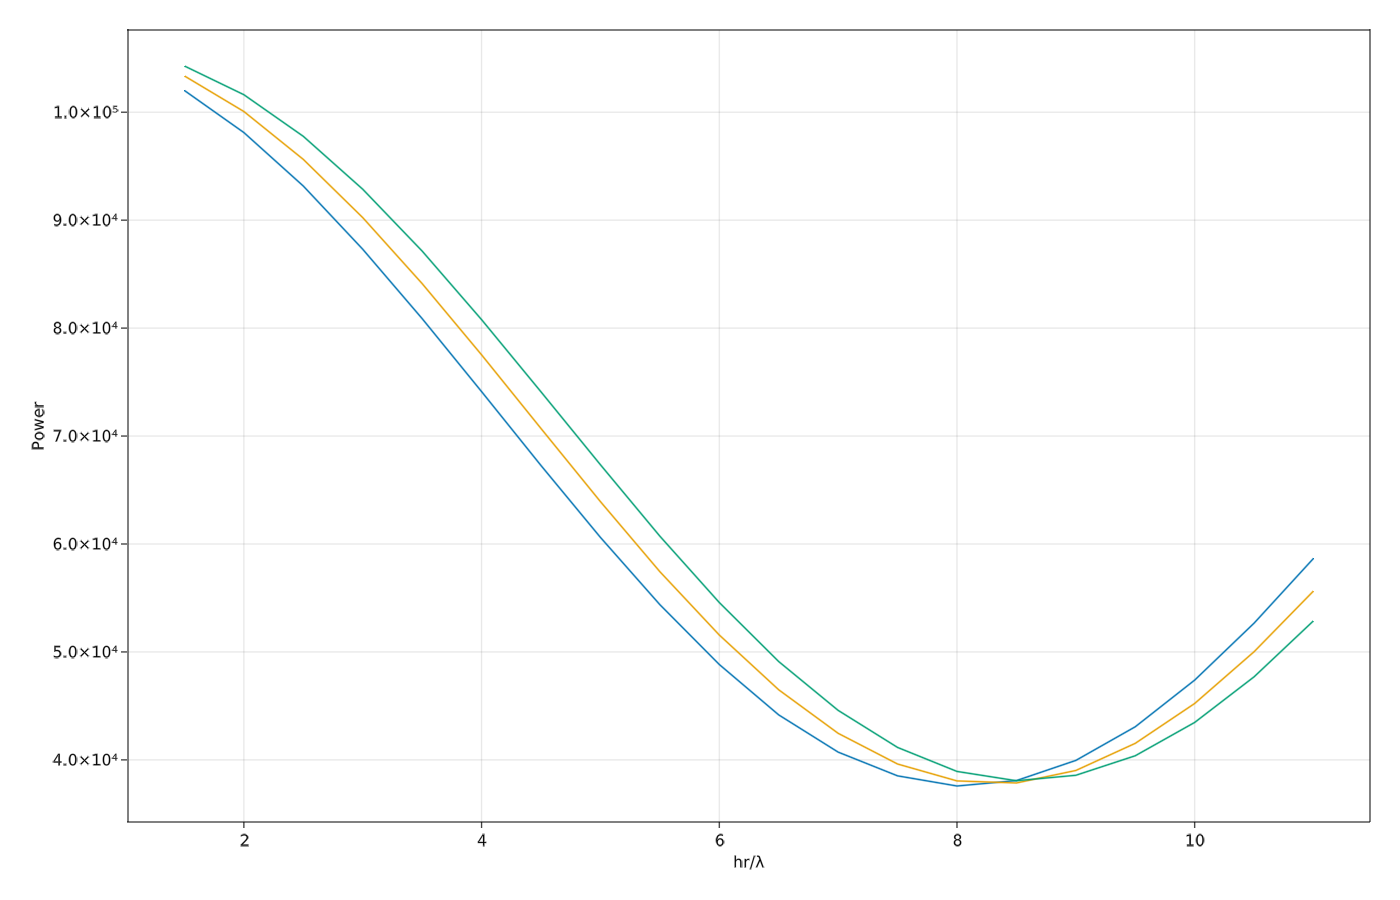

In [19]:
scene, layout = layoutscene(resolution=(1400,900))
ax = layout[1,1]=Axis(scene)
ms = 10
lin1 = lines!(ax,h_list,g_list)
lin2 = lines!(ax,h_list,g0_list/2)
# lin3 = lines!(ax,h_list,range(1,length(h_list),step=1).*g0_list)
lin4 = lines!(ax,h_list,g1_list/3)

#lin2 = scatter!(ax,range(1,12,step=1),g_r10,markersize=10)
#lin3 = lines!(ax,range(1,12,step=1),gr_r5.+1e-9)
#ax.yscale = log10
ax.xlabel="hr/λ"
ax.ylabel="Power"
#ax.title="Eigenvalue distribution"

# Legend(layout[1,1],[lin1, lin2],["Initial", "Optimized"])
# axislegend(ax, [lin1, lin2, lin3],["All","Far field","Difference"], position = :rt,
#     orientation = :vertical)
# save("Results/EigenValDistributionIO.png",scene)
scene

In [ ]:
open("Bowtie.txt", "w") do iop
    for i = 1 : length(h_list)
        h_temp = h_list[i]
        g_temp = g_list[i]
        write(iop, "$h_temp $g_temp \n")
    end
end

In [ ]:
gh0 = readdlm("FlatSurface.txt")
ghp = readdlm("Bowtie.txt")
h0_list = gh0[:,1]
g0_list = gh0[:,2]
gp_list = ghp[:,2]
GLMakie.lines(h0_list, gp_list-g0_list)

In [ ]:
(g_list[end]-g0_list[end])./g0_list[end]